## Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
#import scikit-learn as sci
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = '../../results/fitz_control_day6.h5ad'  # the file that will store the analysis results

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 pynndescent==0.5.5


In [18]:
    #Read in the count matrix into an AnnData object, which holds many slots for annotations and different 
    #representations of the data.

adata = sc.read_10x_mtx(
   '../../data/endometrial_organoids_fritzgeraldetal/',  # the directory with the `.mtx` file
   prefix='GSM4927792_sample1_control_day6_',
   var_names='gene_symbols',              # use gene symbols for the variable names (variables-axis index)
   cache=True)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()

... reading from cache file cache/..-..-data-endometrial_organoids_fritzgeraldetal-GSM4927792_sample1_control_day6_matrix.h5ad


## Preprocessing the Data

normalizing counts per cell
    finished (0:00:00)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


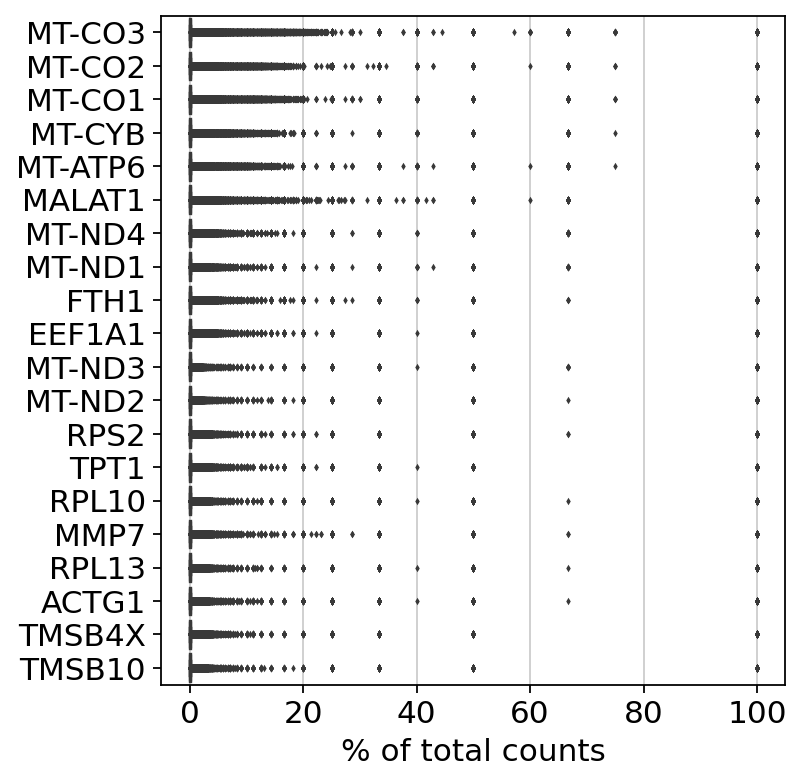

filtered out 6790173 cells that have less than 200 genes expressed
filtered out 13749 genes that are detected in less than 3 cells


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


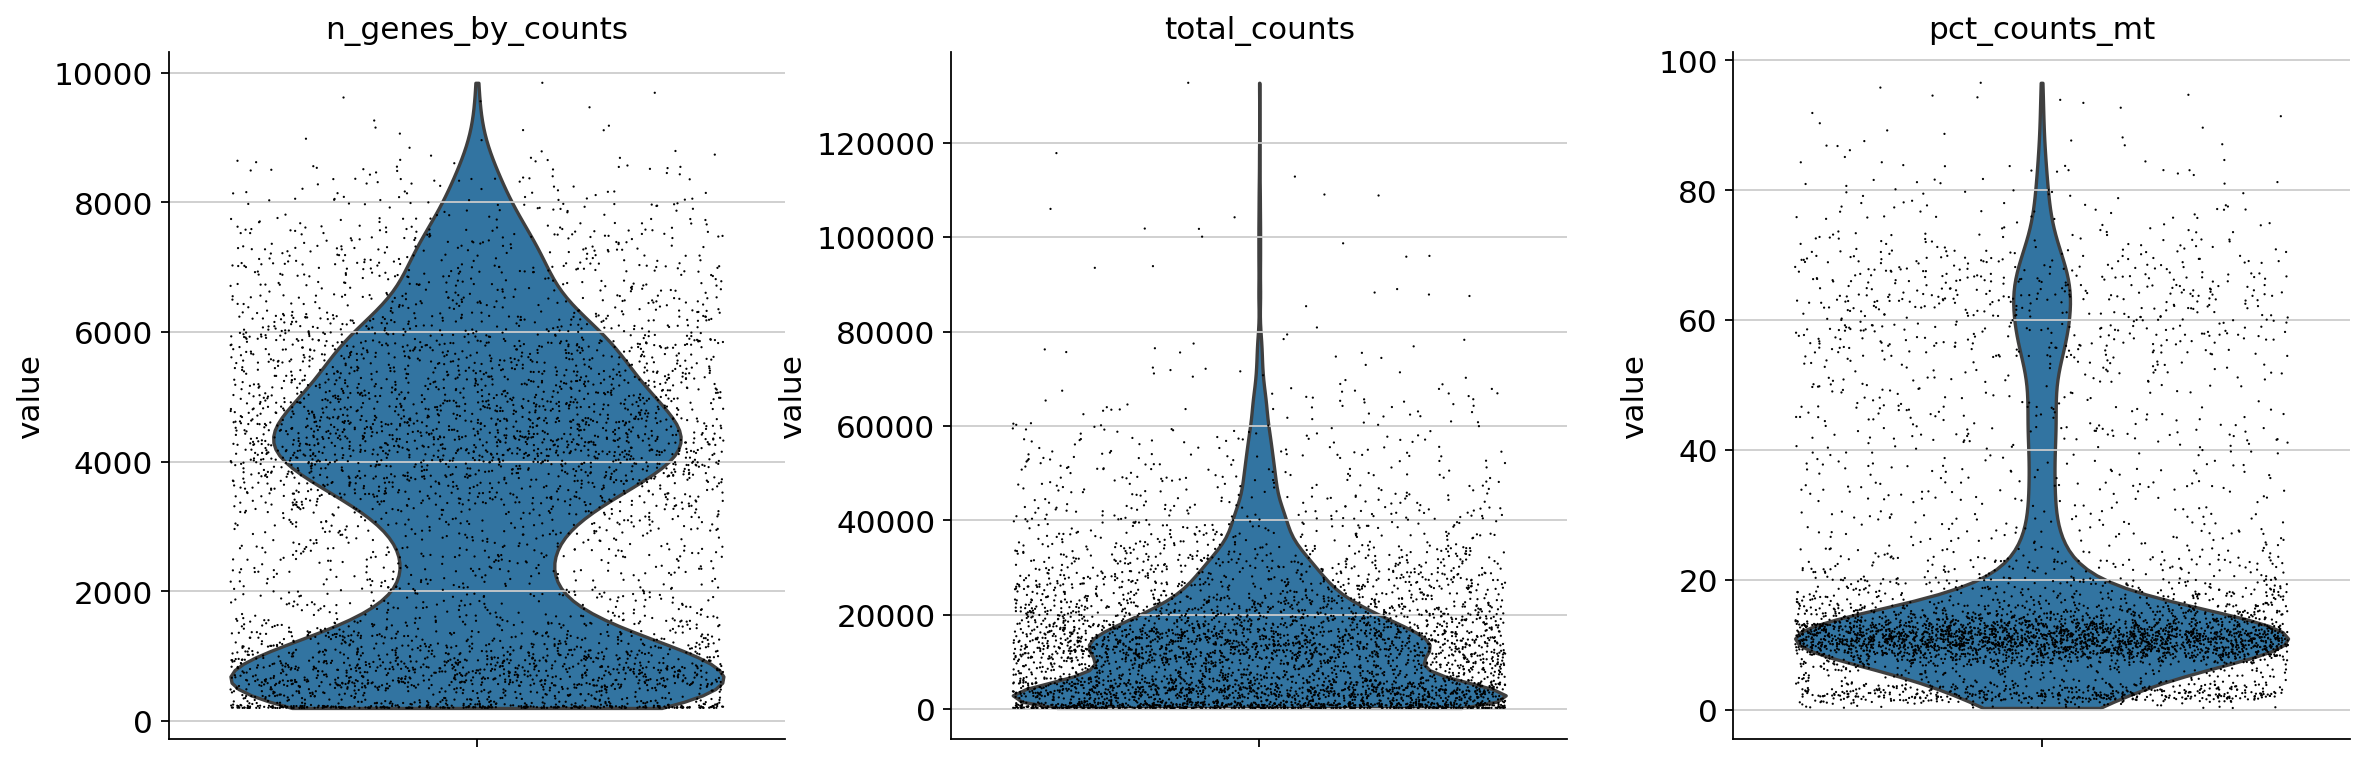

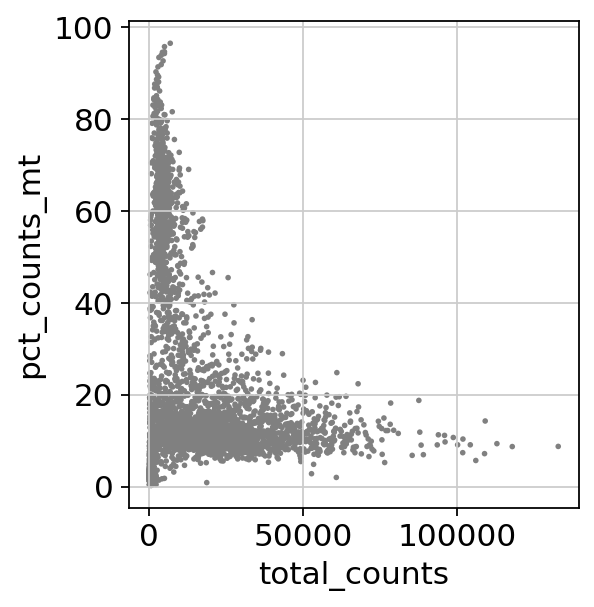

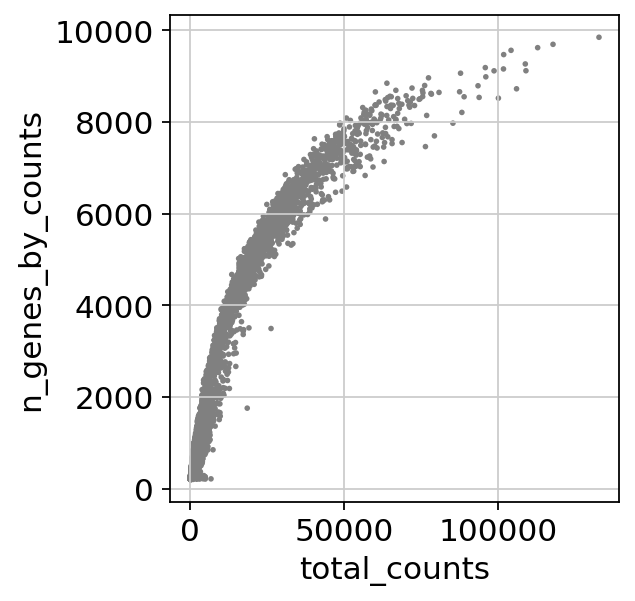

In [19]:
    #Show those genes that yield the highest fraction of counts in each single cell, across all cells.

sc.pl.highest_expr_genes(adata, n_top=20, ) #ln8

    #MITOCHONDRIAL GENES: High proportions are indicative of poor-quality cells, possibly because of loss of cytoplasmic RNA
    #from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less 
    #likely to escape through tears in the cell membrane.

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) #ln9

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #ln10

    #VIOLIN PlOTS: 1) number of genes expressed in the count matrix, 2) total counts per cell, 
    #3) percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True) #ln11

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts') #ln12

### Acutually filter the data & remove cells that have too many mitochondrial genes expressed / too many total counts

In [20]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
#adata = adata[adata.obs.total_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :] #ln13

normalizing counts per cell
    finished (0:00:00)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


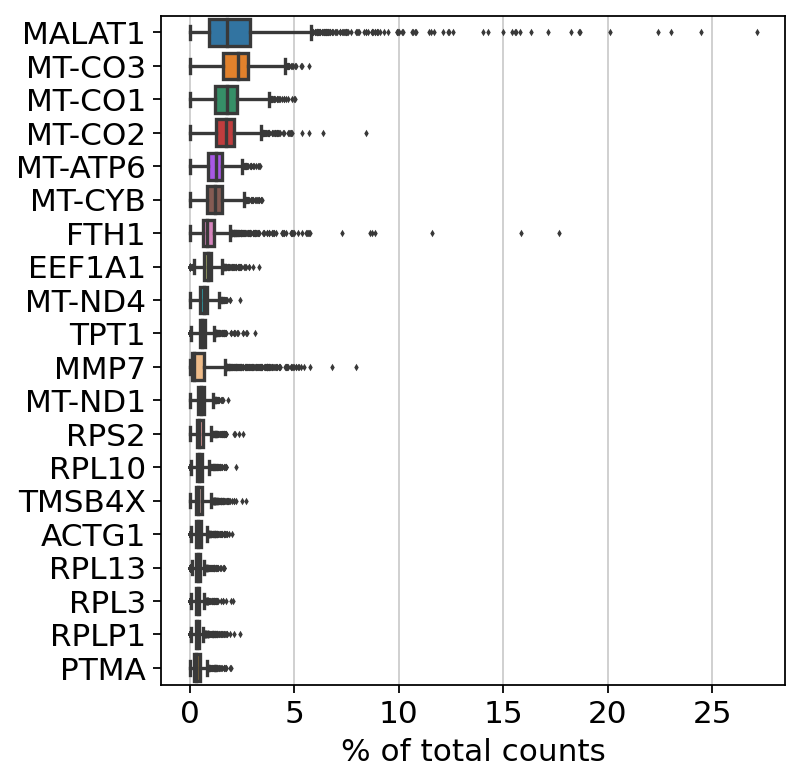

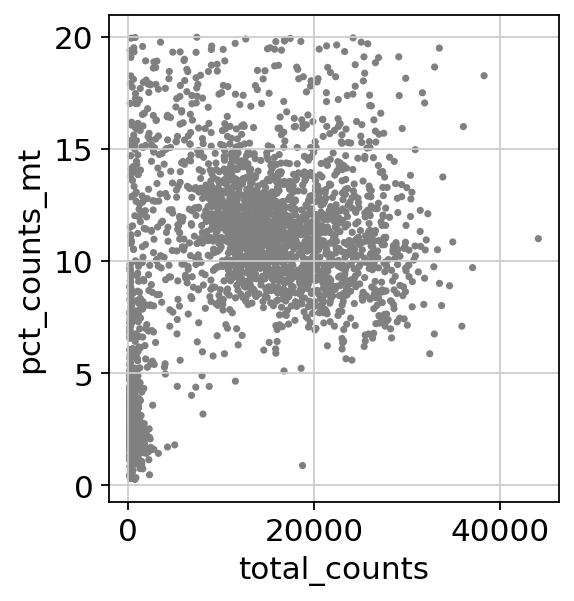

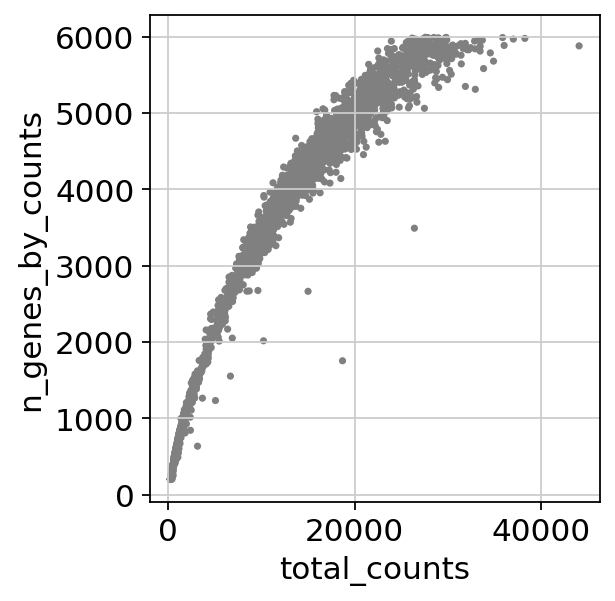

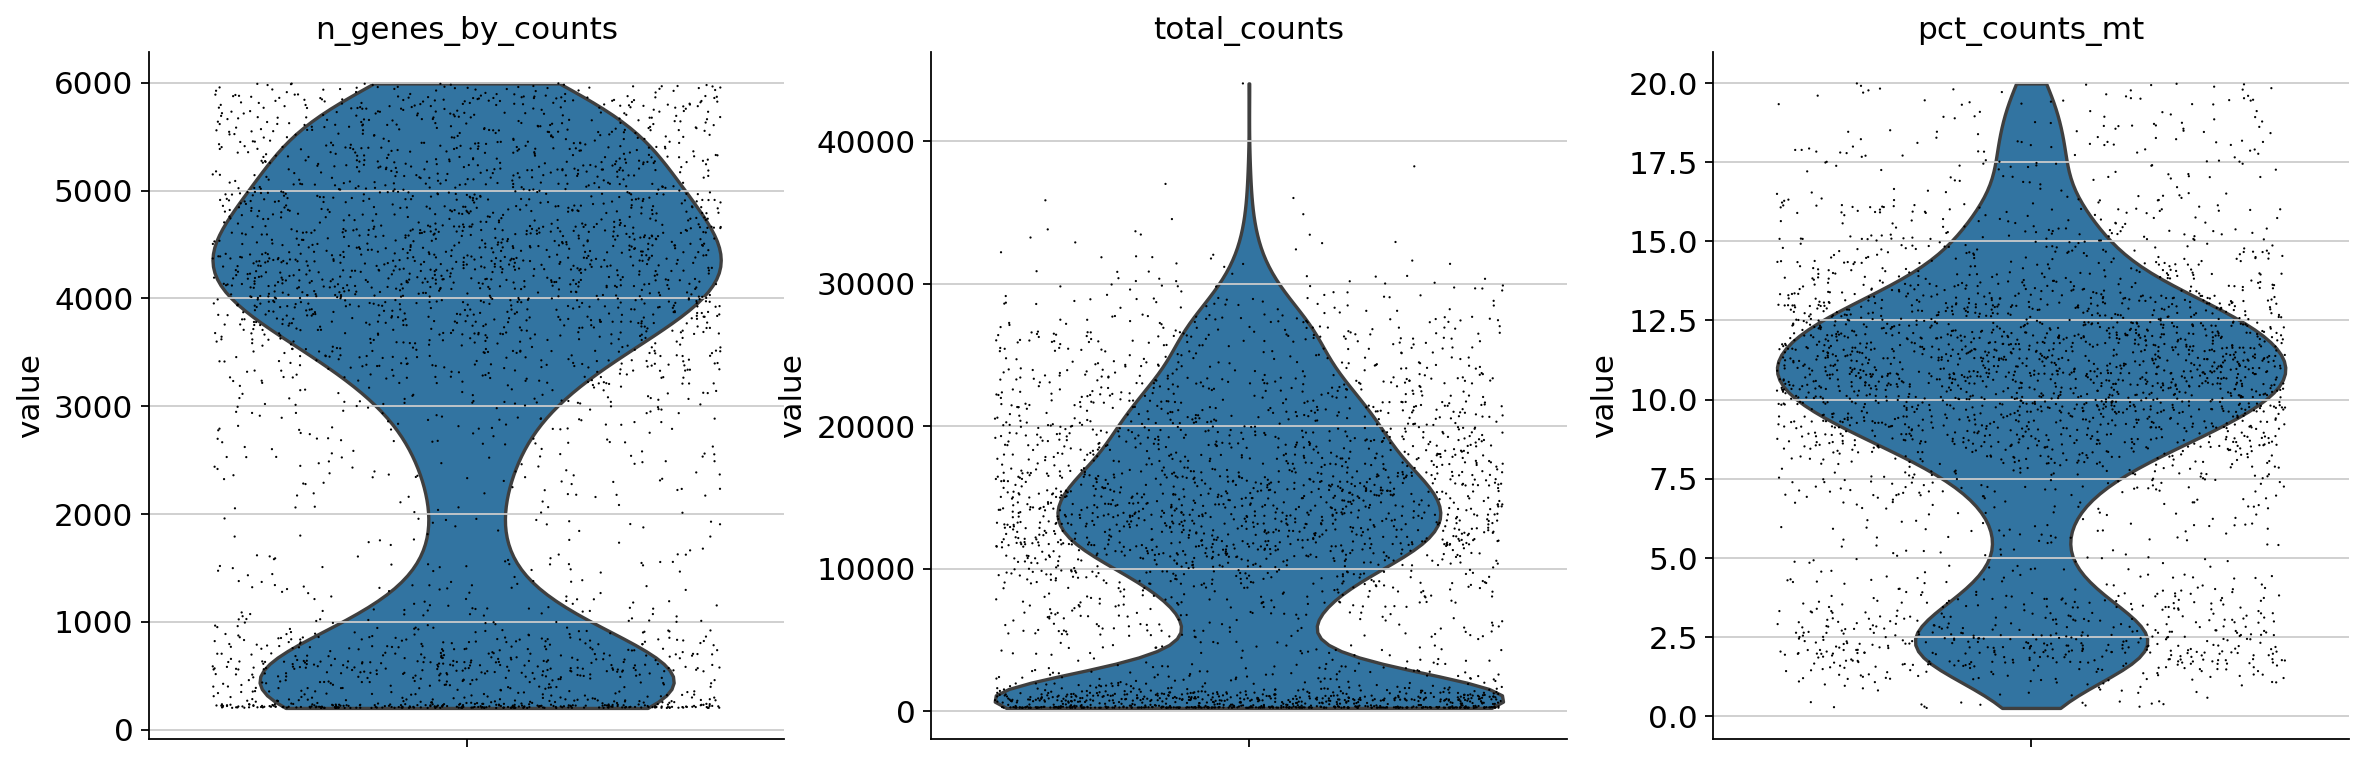

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, ) 

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts') #ln12

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [22]:
    #Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, 
    #so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4) #ln14

normalizing counts per cell
    finished (0:00:00)


In [23]:
    #Logarithmize the data:
sc.pp.log1p(adata) #ln15

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


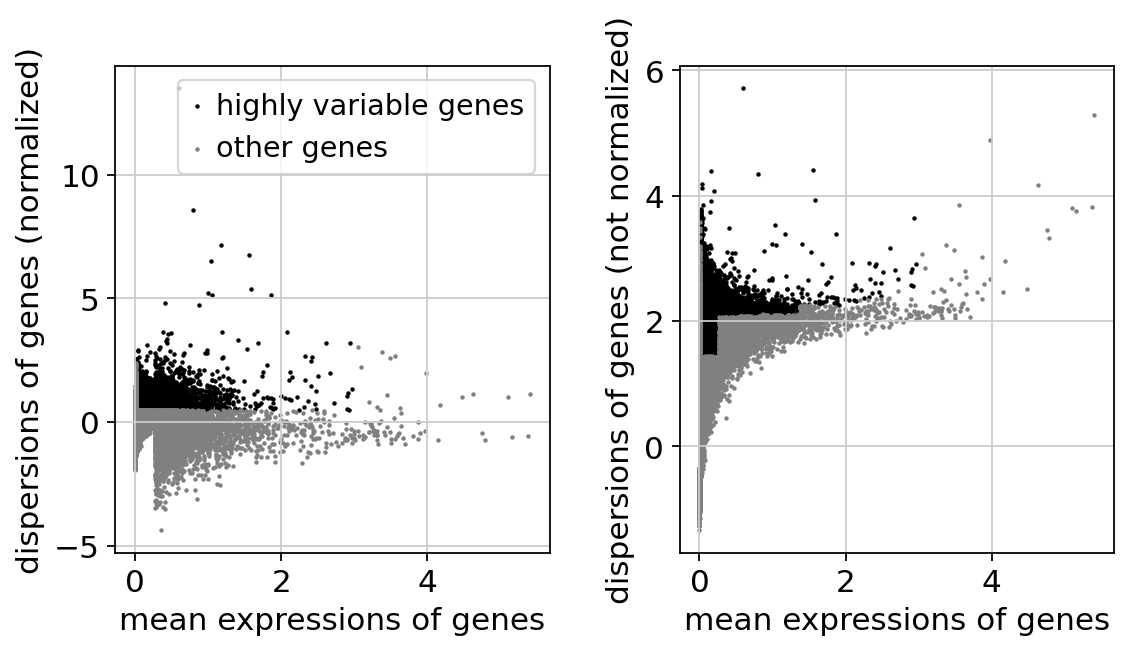

In [24]:
    #Indentify highly-variable genes:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #ln16
sc.pl.highly_variable_genes(adata) #ln17

In [25]:
    #Freeze state of the AnnData object:
adata.raw = adata #ln18

In [26]:
adata = adata[:, adata.var.highly_variable] #19

In [27]:
    #Reress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit
    #variance:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #20

In [28]:
    #Scale each gene to unit variance. Clip values exceeding standard deviation 10:
sc.pp.scale(adata, max_value=10) #ln21

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Principal Component Analysis (PCA)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


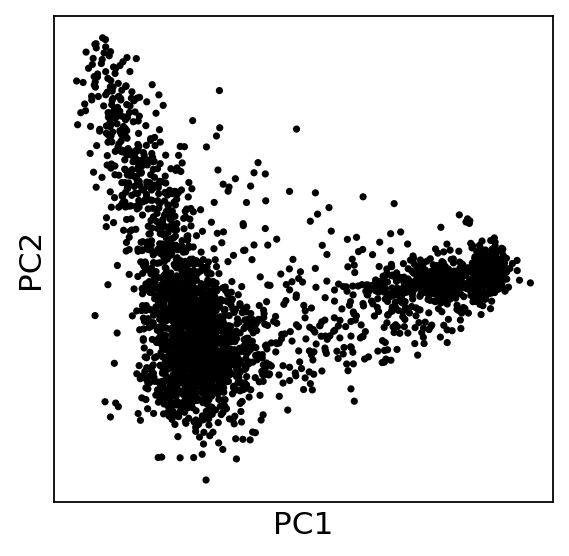

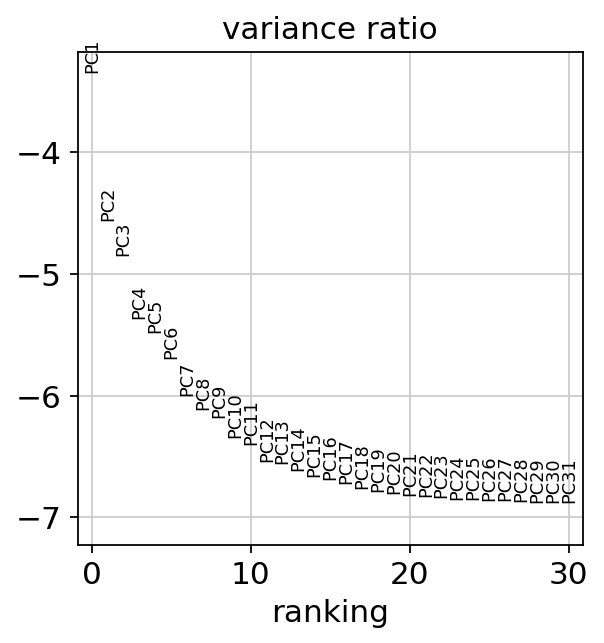

In [39]:
    #Reduce the dimensionality of the data by running PCA: reveals the main axes of variation and denoises the data.

sc.tl.pca(adata, svd_solver='arpack') #ln22

sc.pl.pca(adata, na_color='black') #ln23

    #Contribution of single PCs to the total variance of the data. 
sc.pl.pca_variance_ratio(adata, log=True) #ln24

In [36]:
help(sc.pl.pca)

Help on function pca in module scanpy.plotting._tools.scatterplots:

pca(adata: anndata._core.anndata.AnnData, *, color: Union[str, Sequence[str], NoneType] = None, gene_symbols: Union[str, NoneType] = None, use_raw: Union[bool, NoneType] = None, sort_order: bool = True, edges: bool = False, edges_width: float = 0.1, edges_color: Union[str, Sequence[float], Sequence[str]] = 'grey', neighbors_key: Union[str, NoneType] = None, arrows: bool = False, arrows_kwds: Union[Mapping[str, Any], NoneType] = None, groups: Union[str, NoneType] = None, components: Union[str, Sequence[str]] = None, layer: Union[str, NoneType] = None, projection: Literal['2d', '3d'] = '2d', scale_factor: Union[float, NoneType] = None, color_map: Union[matplotlib.colors.Colormap, str, NoneType] = None, cmap: Union[matplotlib.colors.Colormap, str, NoneType] = None, palette: Union[str, Sequence[str], cycler.Cycler, NoneType] = None, na_color: Union[str, Tuple[float, ...]] = 'lightgray', na_in_legend: bool = True, size: Un

In [15]:
#adata.write(results_file) #ln25

#adata #ln26

## Computing the neighborhood graph

In [40]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8) #ln27

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

In [37]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')

In [41]:
sc.tl.umap(adata) #ln28

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


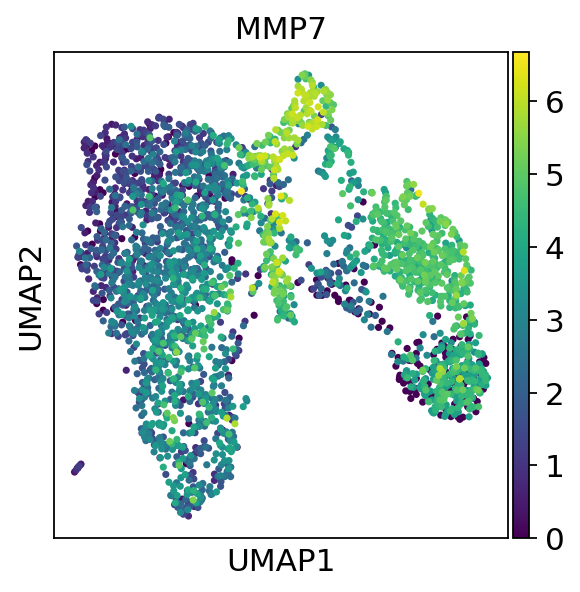

In [44]:
sc.pl.umap(adata, color=['MMP7']) #ln29 #'MMP7', 'RPS2', 'PTMA'

## Clustering the neighborhood graph

In [46]:
sc.tl.leiden(adata) #ln31

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [47]:
print(adata.var_names)

Index(['LINC00115', 'AL645608.8', 'HES4', 'ISG15', 'RNF223', 'C1orf159',
       'AL390719.2', 'TNFRSF18', 'B3GALT6', 'UBE2J2',
       ...
       'AP001059.2', 'C21orf2', 'TRPM2', 'LRRC3', 'ITGB2-AS1', 'ADARB1',
       'POFUT2', 'COL6A1', 'YBEY', 'DIP2A'],
      dtype='object', length=6428)


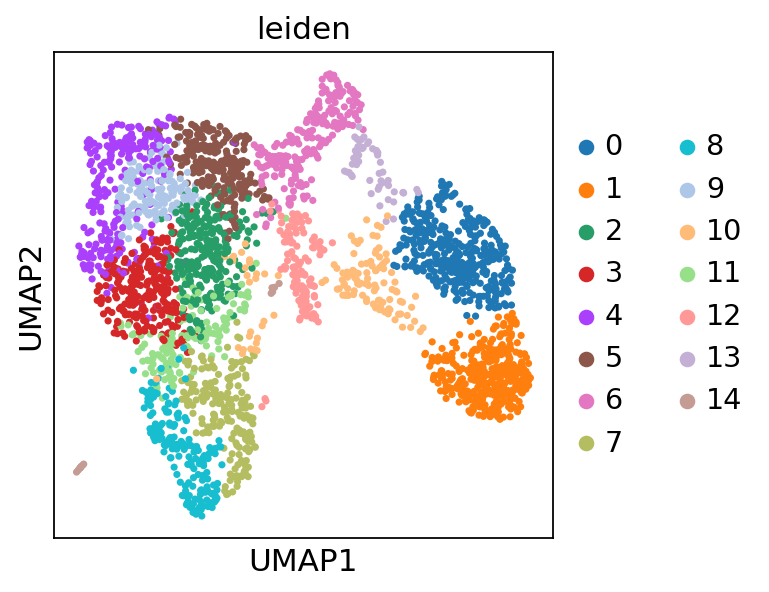

In [48]:
sc.pl.umap(adata, color=['leiden']) #ln32

In [49]:
adata.write(results_file) #ln33

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


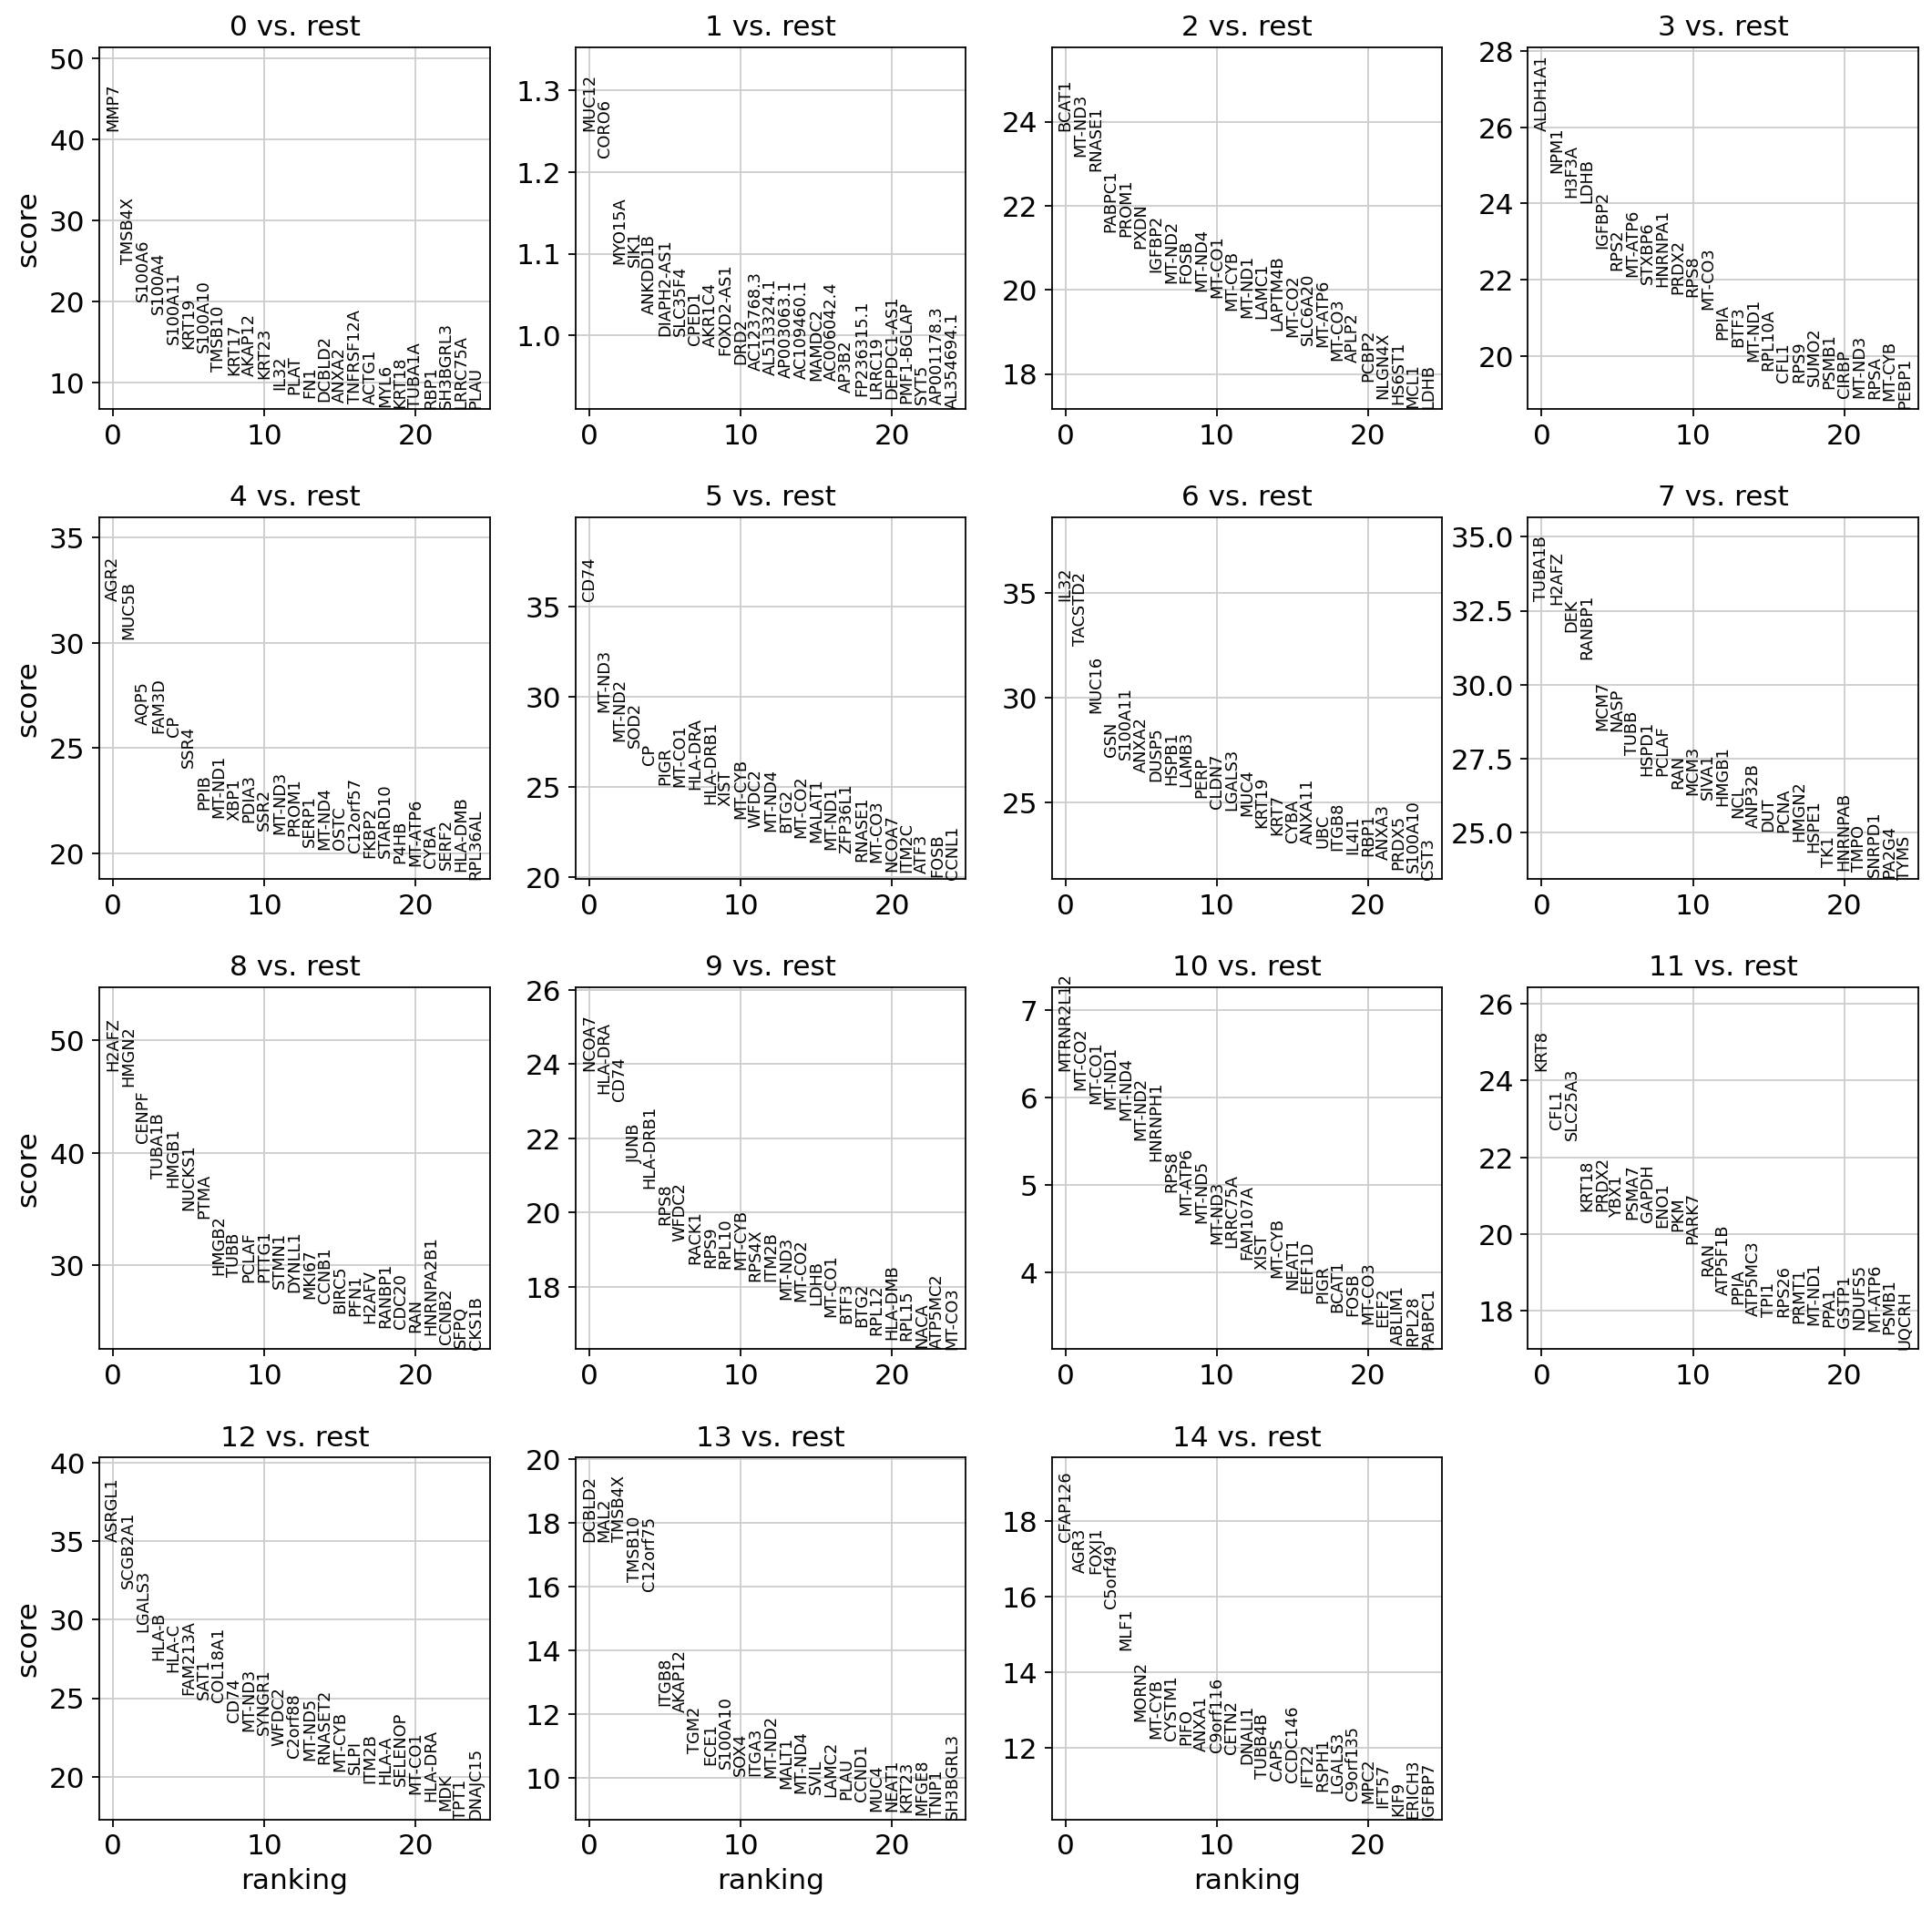

ranking genes
    finished (0:00:04)


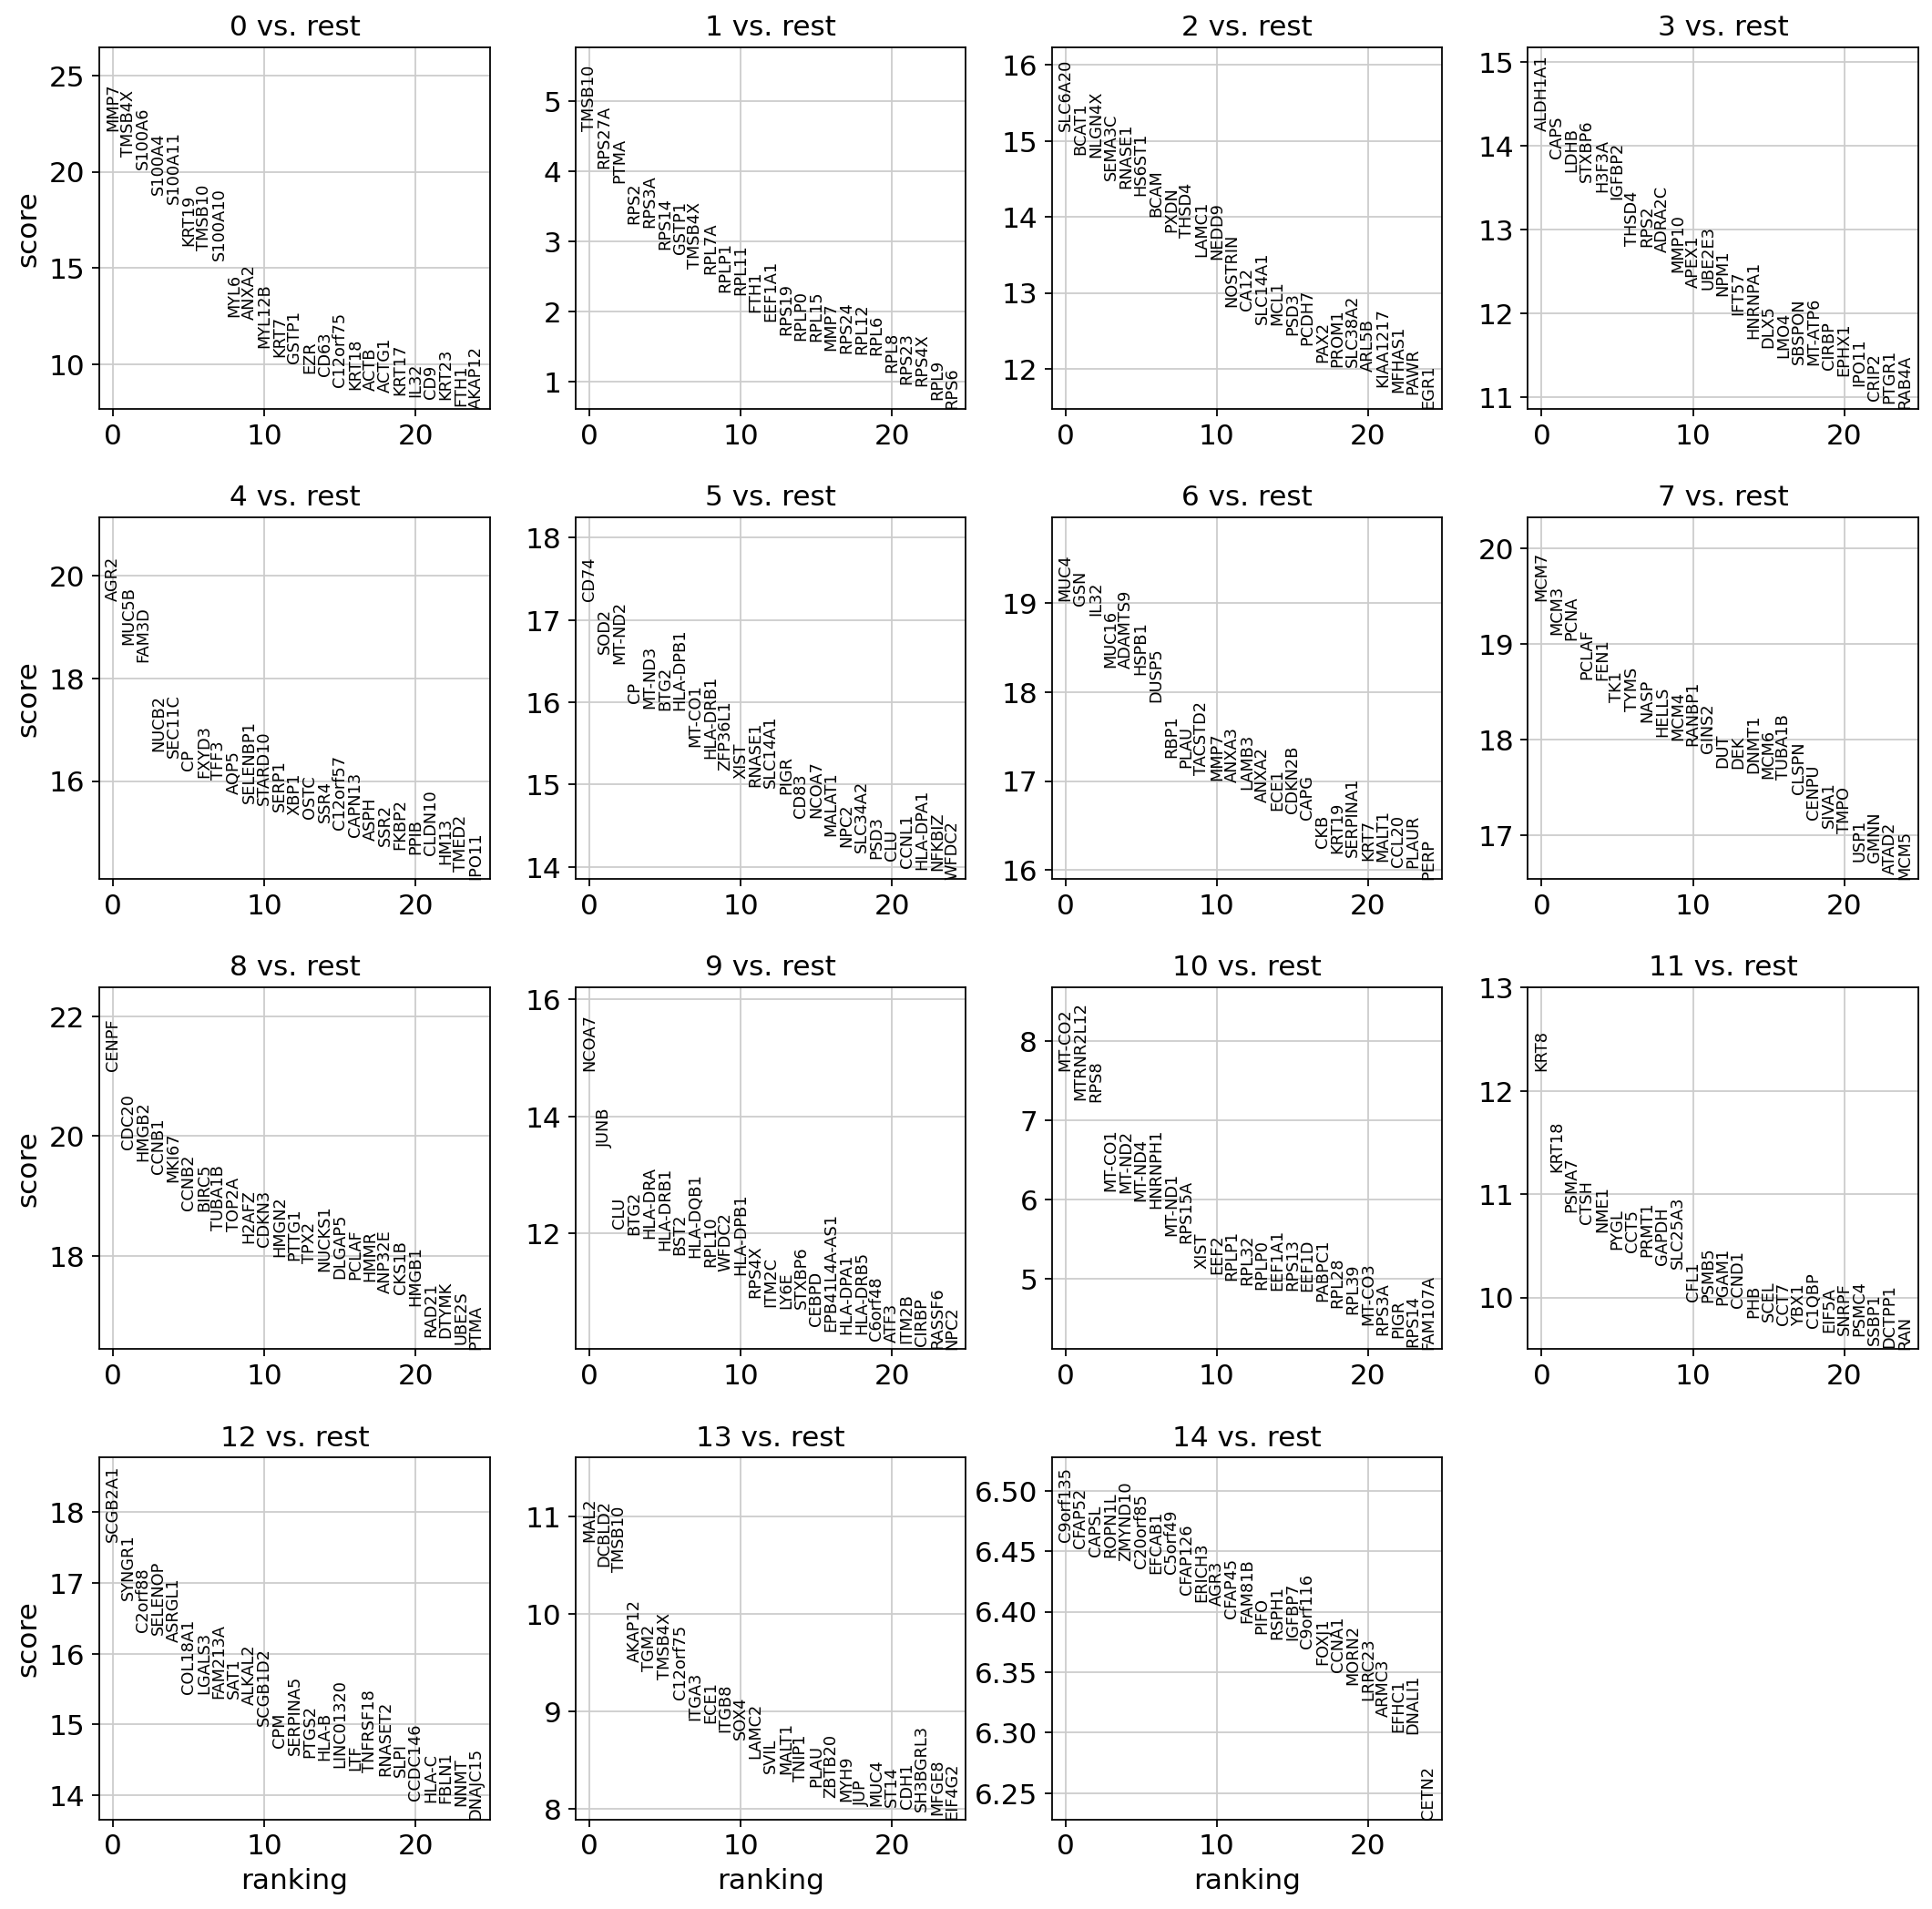

ranking genes
    finished (0:00:26)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


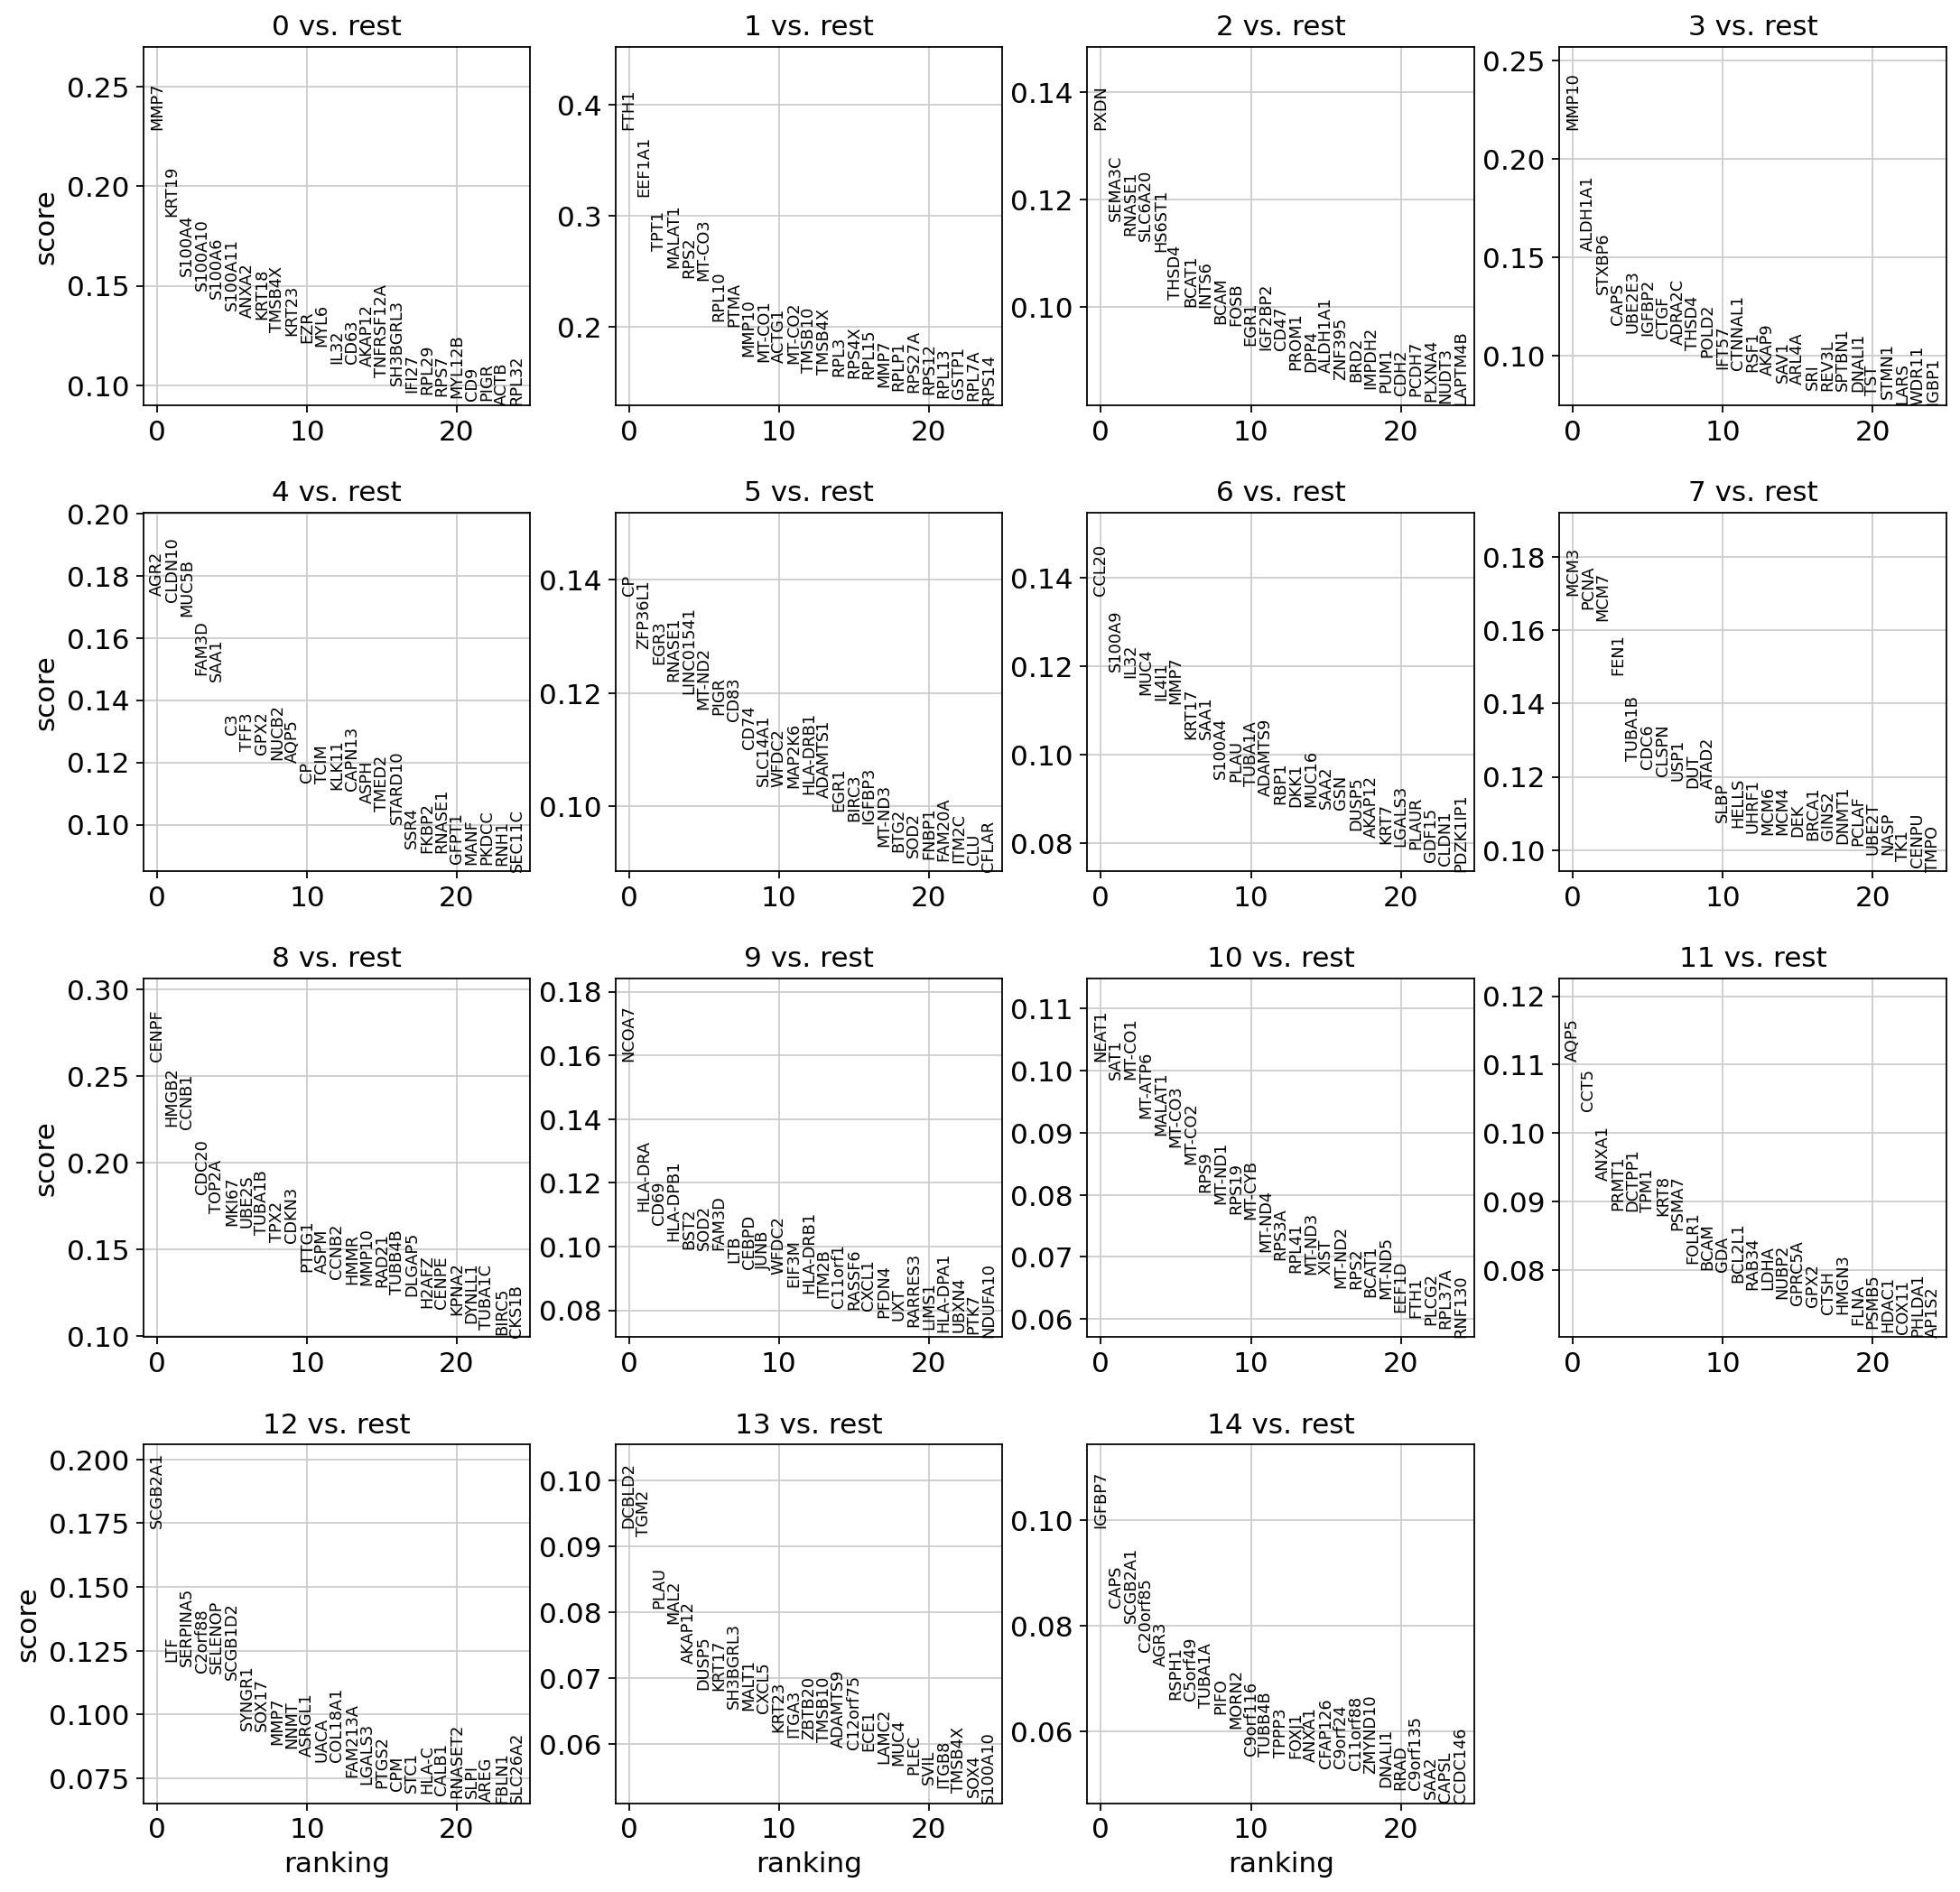

In [50]:
    #t-test: compute a ranking for the highly differential genes in each cluster:

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln34

sc.settings.verbosity = 2  # reduce the verbosity #ln35

    #result of a Wilcoxon rank-sum test:

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln36

adata.write(results_file) #ln37

    #rank genes using logistic regression:

sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln38

In [ ]:
#marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
#                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
#                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP'] #ln39
#
#genes_list = ['NCR3', 'MMP1', 'MMP3', 'MMP10', 'Wnt5', 'Wnt7a', 'MMP26', 'TFF3', 'Hoxa10', 'Hoxa11', 'Conenxin-37', 
#              'Hoxb7', 'sFRP', 'MMP11', 'tPA', 'PLAT', 'ADAM12', 'IGF', 'TGF', 'FGF1', 'HGF', 'FGFR3']
#
#top_20_Organoid_Control = ['FTH1', 'MALAT1', 'EEF1A1', 'MT-CO3', 'TPT1', 'MT-CO1', 'RPS2', 'TMSB4X', 'MT-CO2', 
#          'RPL10', 'MT-ATP6', 'MMP7', 'RPL13', 'PTMA', 'MT-CYB', 'ACTG1', 'RPL3', 'RPLP1', 
#          'RPS12', 'RPS18']
#
#genes_epi = ['PLAU', 'MMP7', 'THBS1', 'CADM1', 'NPAS3', 'ATP1A1', 'ANK3', 'ALPL', 'TRAK1', 
#         'SCGB1D2', 'MT1F', 'MT1X', 'MT1E', 'MT1G', 'CXCL14', 'MAOA', 'DPP4', 'NUPR1', 'GPX3'
#        'PAEP']
#
#genes_str = ['STC1', 'NFATC2', 'BMP2', 'PMAIP1', 'MMP11', 'SFRP1', 'WNT5A', 'ZFYVE21', 'CILP', 
#             'SLF2', 'MATN2', 'S100A4', 'DKK1', 'CRYAB', 'FOXO1', 'IL15', 'FGF7', 'LMCD1']
#
#genes_early = ['MMP26', 'TFF3', 'Hoxa10', 'Hoxa11', 'Conenxin-37', 'Hoxb7', 'sFRP', 'WIF', 'TGFB2', 'CCL18', 'PGR', 'ESR1'] 
#
#genes_late = ['SOX4', 'ADAMTS5', 'GNG4', 'Integrina2', 'EBAF', 'MMP7', 'proMMP3', 'EDNRB', 'MMP10', 'MMP', 'PLAU', 'PLAT', 
#              'ADAM', 'PAEP', 'CIQTNF6'] 
#
#important_genes = []

In [51]:
    #reload the object that has been saved with the Wilcoxon Rank-Sum test result:

adata = sc.read(results_file) #ln40

In [52]:
    #show the 10 top ranked genes per cluster in a dataframe:

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10) #ln41

0       1        2        3         4         5        6      7  \
0     MMP7  TMSB10  SLC6A20  ALDH1A1      AGR2      CD74     MUC4   MCM7   
1   TMSB4X  RPS27A    BCAT1     CAPS     MUC5B      SOD2      GSN   MCM3   
2   S100A6    PTMA   NLGN4X     LDHB     FAM3D    MT-ND2     IL32   PCNA   
3   S100A4    RPS2   SEMA3C   STXBP6     NUCB2        CP    MUC16  PCLAF   
4  S100A11   RPS3A   RNASE1    H3F3A    SEC11C    MT-ND3  ADAMTS9   FEN1   
5    KRT19   RPS14   HS6ST1   IGFBP2        CP      BTG2    HSPB1    TK1   
6   TMSB10   GSTP1     BCAM    THSD4     FXYD3  HLA-DPB1    DUSP5   TYMS   
7  S100A10  TMSB4X     PXDN     RPS2      TFF3    MT-CO1     RBP1   NASP   
8     MYL6   RPL7A    THSD4   ADRA2C      AQP5  HLA-DRB1     PLAU  HELLS   
9    ANXA2   RPLP1    LAMC1    MMP10  SELENBP1   ZFP36L1  TACSTD2   MCM4   

        8         9         10       11       12        13        14  
0   CENPF     NCOA7     MT-CO2     KRT8  SCGB2A1      MAL2  C9orf135  
1   CDC20      JUNB  MTRNR2L12    KRT18   SYNGR1    DCBLD2    CFAP52  
2   HMGB2       CLU       RPS8    PSMA7  C2orf88    TMSB10     CAPSL  
3   CCNB1      BTG2     MT-CO1     CTSH  SELENOP    AKAP12    ROPN1L  
4   MKI67   HLA-DRA     MT-ND2     NME1   ASRGL1      TGM2   ZMYND10  
5   CCNB2  HLA-DRB1     MT-ND4     PYGL  COL18A1    TMSB4X  C20orf85  
6   BIRC5      BST2    HNRNPH1     CCT5   LGALS3  C12orf75    EFCAB1  
7  TUBA1B  HLA-DQB1     MT-ND1    PRMT1  FAM213A     ITGA3   C5orf49  
8   TOP2A     RPL10     RPS15A    GAPDH     SAT1      ECE1   CFAP126  
9   H2AFZ     WFDC2       XIST  SLC25A3   ALKAL2     ITGB8    ERICH3

In [53]:
    #Get a table with the scores and groups:

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5) #ln42

0_n            0_p     1_n       1_p      2_n           2_p      3_n  \
0     MMP7  1.488512e-108  TMSB10  0.000005  SLC6A20  9.534540e-52  ALDH1A1   
1   TMSB4X   5.330982e-96  RPS27A  0.000052    BCAT1  1.041453e-49     CAPS   
2   S100A6   2.052335e-90    PTMA  0.000125   NLGN4X  1.646318e-49     LDHB   
3   S100A4   5.428479e-79    RPS2  0.001154   SEMA3C  1.352467e-47   STXBP6   
4  S100A11   4.587610e-75   RPS3A  0.001372   RNASE1  7.309333e-47    H3F3A   

            3_p     4_n           4_p  ...       10_n          10_p   11_n  \
0  1.253897e-45    AGR2  8.179050e-85  ...     MT-CO2  2.475701e-14   KRT8   
1  1.331270e-43   MUC5B  9.647780e-78  ...  MTRNR2L12  3.795816e-13  KRT18   
2  1.112761e-42   FAM3D  5.619115e-75  ...       RPS8  4.561002e-13  PSMA7   
3  6.582900e-42   NUCB2  7.791894e-62  ...     MT-CO1  9.968185e-10   CTSH   
4  3.069340e-41  SEC11C  7.979842e-61  ...     MT-ND2  1.167646e-09   NME1   

           11_p     12_n          12_p    13_n          13_p      14_n  \
0  3.386671e-34  SCGB2A1  2.937979e-69    MAL2  5.955755e-27  C9orf135   
1  3.253888e-29   SYNGR1  4.910666e-63  DCBLD2  9.076206e-26    CFAP52   
2  2.419867e-27  C2orf88  8.890572e-60  TMSB10  1.744287e-25     CAPSL   
3  8.698765e-27  SELENOP  1.461001e-59  AKAP12  1.977989e-21    ROPN1L   
4  1.964984e-26   ASRGL1  7.987763e-59    TGM2  4.684647e-21   ZMYND10   

           14_p  
0  1.058528e-10  
1  1.097559e-10  
2  1.147719e-10  
3  1.155065e-10  
4  1.177381e-10  

[5 rows x 30 columns]

ranking genes
    finished (0:00:00)


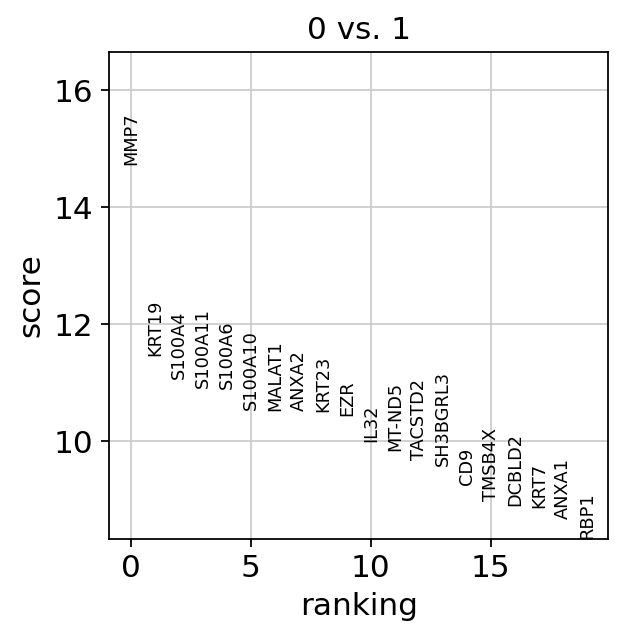

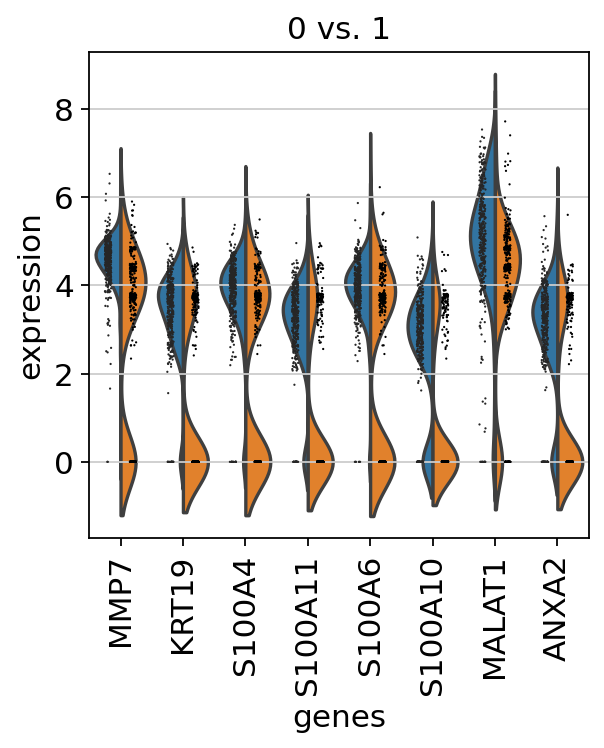

In [54]:
    #Compare to a single cluster:

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20) #ln43

    #more detailed view for a certain group:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

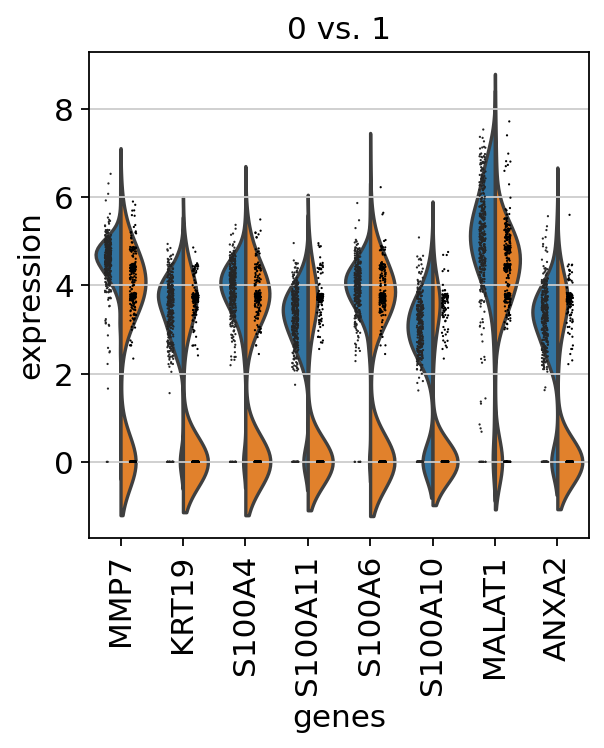

In [55]:
    #reload the objects with the computed differential expression:
#adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

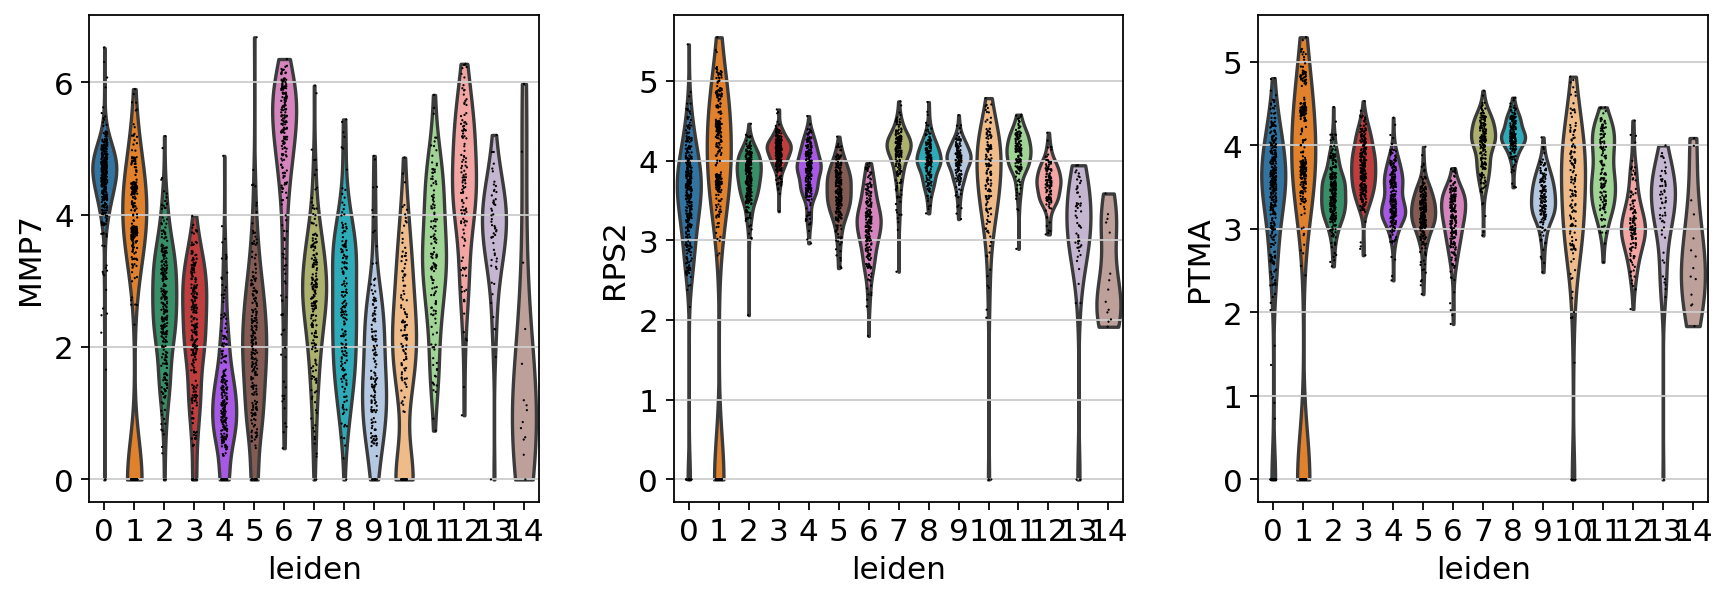

In [57]:
    #If we want to compare a certain gene across groups:
sc.pl.violin(adata, ['MMP7', 'RPS2', 'PTMA'], groupby='leiden')

In [58]:
    #actually mark/annotate the cell types:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


ValueError: new categories need to have the same number of items as the old categories!

In [56]:
    #visualize the marker genes:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

NameError: name 'marker_genes' is not defined

## dotplot

In [ ]:
    #quick way to check the expression of genes

sc.pl.dotplot(adata, marker_genes, 'clusters', dendrogram=True)

## matrixplot

In [ ]:
sc.pl.matrixplot(adata, marker_genes, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

# scale and store results in layer
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X

sc.pl.matrixplot(adata, marker_genes, 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

## Heatmaps

In [ ]:
ax = sc.pl.heatmap(adata, marker_genes, groupby='clusters', cmap='viridis', dendrogram=True, swap_axes=True)

sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);